In [1]:
import pandas as pd
from urllib.request import Request, urlopen
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
import re
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tensorflow as tf
pd.set_option('display.max_rows', None)

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [30]:
df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/price_df_10mins_furtherpreprocess_24hvol.csv')
df['tx_timestamp'] = pd.to_datetime(df['tx_timestamp'],unit='ns')
df = df.rename(columns = {"tx_timestamp":"timestamp","0":"volatility"})
display(df.head(3))
df.tail()
df = df.set_index('timestamp')
vol_df =df[['24rolling_vol']]*np.sqrt(365)
ret_df = df[['ret']].fillna(0)

,Unnamed: 0,timestamp,first,last,mean,vol_of_vol,max,min,ret,24rolling_vol
0,0,2020-05-26 21:00:00+00:00,201.177211,201.177211,201.0,NaN,201.177211,201.177211,0.0,NaN
1,1,2020-05-26 21:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-05-26 21:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df.tail()

,Unnamed: 0,first,last,mean,vol_of_vol,max,min,ret,24rolling_vol
timestamp,,,,,,,,,
2022-10-30 13:50:00+00:00,127685,1593.069968,1591.725668,1590.000000,4.031129,1593.592900,1582.369607,-0.000844,0.004805
2022-10-30 14:00:00+00:00,127686,1591.752575,1579.893707,1585.600000,4.860149,1591.752575,1579.893707,-0.007450,0.004798
2022-10-30 14:10:00+00:00,127687,1579.795094,1581.087842,1586.562500,4.746490,1590.615992,1579.691428,0.000818,0.004794
2022-10-30 14:20:00+00:00,127688,1581.079224,1595.250643,1590.357143,4.620520,1595.250643,1581.079224,0.008963,0.004857
2022-10-30 14:30:00+00:00,127689,1585.692455,1595.494499,1591.666667,4.923660,1595.494499,1585.692455,0.006182,0.004841


In [32]:
vol_df = vol_df.fillna(method ='ffill')
vol_df = vol_df.fillna(0)

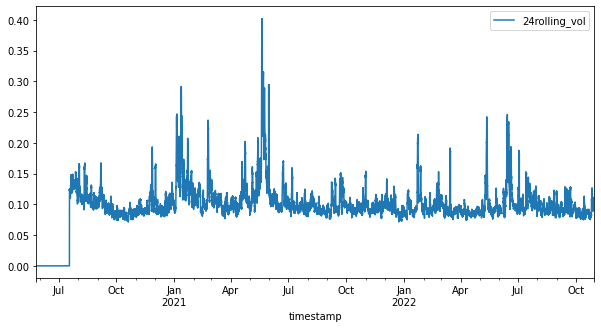

In [33]:
vol_df.plot(figsize =(10,5))

In [34]:
def get_training_data_split(df, train_start,train_end,dev_start,dev_end,test_start, test_end):
    train_dates = df[((df.index >= train_start) & (df.index <= train_end))].values
    dev_dates = df[((df.index >= dev_start) & (df.index <= dev_end))].values
    test_dates = df[((df.index >= test_start) & (df.index <= test_end))].values
    return train_dates, dev_dates,test_dates


In [35]:
def get_MAPE(prediction, y):
    MAPE = mean_absolute_percentage_error(prediction, y)
    return MAPE

In [36]:
def get_corr(prediction,y):
    prediction_df = pd.DataFrame(prediction)
    y_df          = pd.DataFrame(y)
    concated_df   = pd.concat([prediction_df, y_df],axis =1)
    return concated_df.corr().iloc[0,1]

In [37]:
def get_predictions(model, train_data_gen, dev_data_gen):
  trainPredict = model.predict_generator(train_data_gen)
  devPredict = model.predict_generator(dev_data_gen)
  return trainPredict,devPredict

### naive model 

In [38]:
train_start = '2020-05-26'
train_end = '2022-07-31'
dev_start = '2022-08-01'
dev_end = '2022-09-30'
test_start = '2022-10-01'
test_end = '2022-10-31'
days_look_back = 7
n_input = 24*6*days_look_back

In [39]:
train_data, dev_data, test_data =get_training_data_split(vol_df, train_start,train_end,dev_start,dev_end,test_start, test_end)
train_naive_base = pd.DataFrame(train_data).ewm(halflife = n_input).mean()
dev_naive_base = pd.DataFrame(dev_data).ewm(halflife = n_input).mean()

In [40]:
vol_mean =  vol_df.ewm(halflife = n_input).mean()

In [41]:
dev_naive_base = vol_mean [((vol_mean .index >= dev_start) & (vol_mean .index <= dev_end))].values

In [42]:
get_corr(train_naive_base.shift(1),train_data)

0.758802898993819

In [43]:
train_naive_base.tail()

,0
114494,0.109449
114495,0.109440
114496,0.109430
114497,0.109419
114498,0.109409


In [44]:
train_naive_base.head()

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


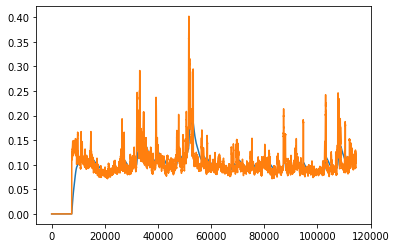

In [45]:
plt.plot()
plt.plot(train_naive_base)
plt.plot(train_data)

In [46]:
get_MAPE(train_naive_base.shift(1).iloc[n_input:],train_data[n_input:])

4828507805.723582

In [47]:
train_naive_base.iloc[n_input:].head()

,0
1008,0.0
1009,0.0
1010,0.0
1011,0.0
1012,0.0


In [48]:
get_MAPE(pd.DataFrame(dev_naive_base).shift(1).iloc[1:],pd.DataFrame(dev_data).iloc[1:])

0.09051468109097419

In [49]:
get_corr(pd.DataFrame(dev_naive_base),pd.DataFrame(dev_data))

0.10299567747749101

In [ ]:
### evaluate LSTM vol

In [50]:
df_price = df.iloc[:,1:-2]
df_price = df_price.drop(columns = 'vol_of_vol')
df = df_price
#df = pd.concat([df_price,vol_df],axis =1)
train_y =  vol_df.fillna(method ='ffill')[((vol_df.index >= train_start) & (vol_df.index <= train_end))].values
dev_y =  vol_df.fillna(method ='ffill')[((vol_df.index >= dev_start) & (vol_df.index <= dev_end))].values
test_y =  vol_df.fillna(method ='ffill')[((vol_df.index >= test_start) & (vol_df.index <= test_end))].values

train_dates = df[((df.index >= train_start) & (df.index <= train_end))].values
dev_dates = df[((df.index >= dev_start) & (df.index <= dev_end))].values
test_dates = df[((df.index >= test_start) & (df.index <= test_end))].values

scaler = MinMaxScaler()
scaler.fit(train_dates)
scaler.fit(dev_dates)
scaler.fit(test_dates)

scaled_train_dates = scaler.transform(train_dates)*0.01
scaled_dev_dates = scaler.transform(dev_dates)*0.01
scaled_test_dates = scaler.transform(test_dates)*0.01

days_look_back = 2
n_input = 24*6*days_look_back
n_features = 6
train_data_gen = TimeseriesGenerator(scaled_train_dates  , train_y  ,length=n_input, batch_size=64)
dev_data_gen = TimeseriesGenerator(scaled_dev_dates, dev_y,length=n_input, batch_size=64)
test_data_gen = TimeseriesGenerator(scaled_test_dates, test_y,length=n_input, batch_size=64)


In [51]:
train_dates.shape

(114499, 5)

In [52]:
df.tail()

,first,last,mean,max,min
timestamp,,,,,
2022-10-30 13:50:00+00:00,1593.069968,1591.725668,1590.000000,1593.592900,1582.369607
2022-10-30 14:00:00+00:00,1591.752575,1579.893707,1585.600000,1591.752575,1579.893707
2022-10-30 14:10:00+00:00,1579.795094,1581.087842,1586.562500,1590.615992,1579.691428
2022-10-30 14:20:00+00:00,1581.079224,1595.250643,1590.357143,1595.250643,1581.079224
2022-10-30 14:30:00+00:00,1585.692455,1595.494499,1591.666667,1595.494499,1585.692455


In [53]:
model_path = '/content/gdrive/My Drive/cs230models/model_evaluation/'

In [54]:
lstm64_price_model = tf.keras.models.load_model(model_path +'model_lstm64_dense_pricevol_24hvol.h5')

In [55]:
lstm64_price_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                17920     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________


In [56]:
lstm64_price_trainPredict = lstm64_price_model.predict_generator(train_data_gen)
lstm64_price_devPredict =lstm64_price_model.predict_generator(dev_data_gen)

<ipython-input-56-3d4a653d78b7>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  lstm64_price_trainPredict = lstm64_price_model.predict_generator(train_data_gen)
<ipython-input-56-3d4a653d78b7>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  lstm64_price_devPredict =lstm64_price_model.predict_generator(dev_data_gen)


In [ ]:
### Evaluate the price vol model

In [57]:
lstm64_price_vol_model = tf.keras.models.load_model('/content/gdrive/My Drive/cs230models/model_lstm64_dense_pricevol_24hvol.h5')

In [58]:
lstm64_price_vol_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                18176     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________


In [59]:

df = pd.concat([df,vol_df],axis =1)
df = df.fillna(method = 'ffill')
train_y =  vol_df.fillna(0).fillna(method ='ffill')[((vol_df.index >= train_start) & (vol_df.index <= train_end))].values
dev_y =  vol_df.fillna(0).fillna(method ='ffill')[((vol_df.index >= dev_start) & (vol_df.index <= dev_end))].values
test_y =  vol_df.fillna(0).fillna(method ='ffill')[((vol_df.index >= test_start) & (vol_df.index <= test_end))].values

train_dates = df[((df.index >= train_start) & (df.index <= train_end))].values
dev_dates = df[((df.index >= dev_start) & (df.index <= dev_end))].values
test_dates = df[((df.index >= test_start) & (df.index <= test_end))].values

scaler = MinMaxScaler()
scaler.fit(train_dates)
scaler.fit(dev_dates)
scaler.fit(test_dates)

scaled_train_dates = scaler.transform(train_dates)*0.01
scaled_dev_dates = scaler.transform(dev_dates)*0.01
scaled_test_dates = scaler.transform(test_dates)*0.01

days_look_back = 2
n_input = 24*6*days_look_back
n_features = 6
train_data_gen = TimeseriesGenerator(scaled_train_dates  , train_y  ,length=n_input, batch_size=64)
dev_data_gen = TimeseriesGenerator(scaled_dev_dates, dev_y,length=n_input, batch_size=64)
test_data_gen = TimeseriesGenerator(scaled_test_dates, test_y,length=n_input, batch_size=64)


In [63]:
train_index =  vol_df.fillna(0).fillna(method ='ffill')[((vol_df.index >= train_start) & (vol_df.index <= train_end))].index
dev_index  =  vol_df.fillna(0).fillna(method ='ffill')[((vol_df.index >= dev_start) & (vol_df.index <= dev_end))].index
test_index  =  vol_df.fillna(0).fillna(method ='ffill')[((vol_df.index >= test_start) & (vol_df.index <= test_end))].index

In [60]:
lstm64_price_vol_trainPredict = lstm64_price_vol_model.predict_generator(train_data_gen)
lstm64_price_vol_devPredict =lstm64_price_vol_model.predict_generator(dev_data_gen)

<ipython-input-60-45b2b162c1e0>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  lstm64_price_vol_trainPredict = lstm64_price_vol_model.predict_generator(train_data_gen)
<ipython-input-60-45b2b162c1e0>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  lstm64_price_vol_devPredict =lstm64_price_vol_model.predict_generator(dev_data_gen)


In [73]:
lstm64_price_vol_testPredict =lstm64_price_vol_model.predict_generator(test_data_gen)

<ipython-input-73-641159cc280e>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  lstm64_price_vol_testPredict =lstm64_price_vol_model.predict_generator(test_data_gen)


Text(0.5, 1.0, 'Train input and prediction')

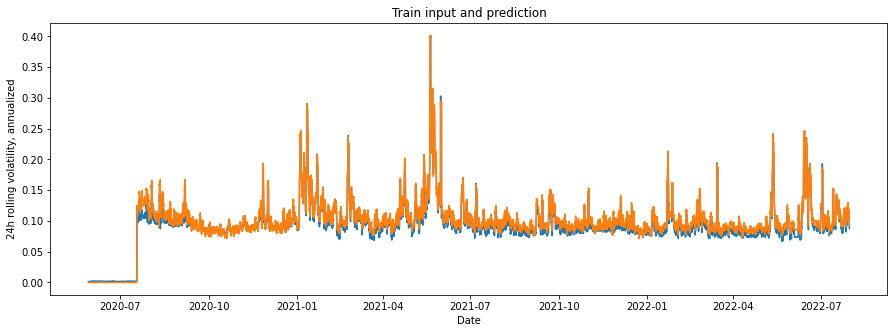

In [71]:
plt.figure(figsize = (15,5))
plt.plot(train_index[24*6*days_look_back:], pd.DataFrame(lstm64_price_vol_trainPredict).fillna(method = 'ffill').values)
plt.plot(train_index[24*6*days_look_back:],pd.DataFrame(train_y[24*6*days_look_back:]).fillna(method ='ffill').values)
plt.xlabel('Date')
plt.ylabel('24h rolling volatility, annualized')
plt.title('Train input and prediction')

Text(0.5, 1.0, 'Dev input and prediction')

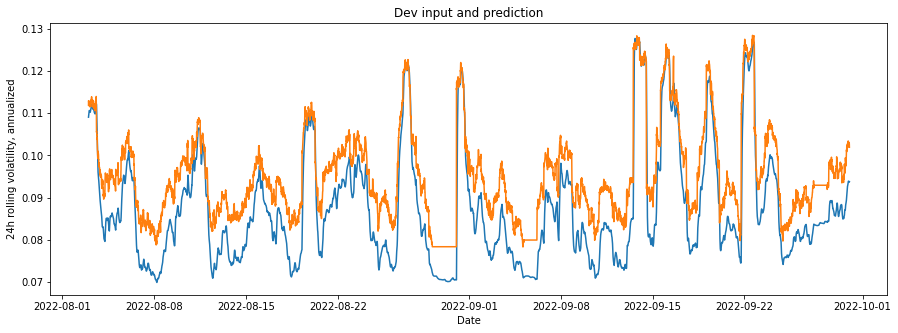

In [72]:
plt.figure(figsize = (15,5))
plt.plot(dev_index[24*6*days_look_back:],pd.DataFrame(lstm64_price_vol_devPredict).fillna(method = 'ffill').values)
plt.plot(dev_index[24*6*days_look_back:],pd.DataFrame(dev_y[24*6*days_look_back:]).fillna(method ='ffill').values)
plt.xlabel('Date')
plt.ylabel('24h rolling volatility, annualized')
plt.title('Dev input and prediction')

In [ ]:
lstm64_price_vol_trainPredict

array([[0.00124581],
       [0.00125138],
       [0.00125665],
       ...,
       [0.08833831],
       [0.08815083],
       [0.0877315 ]], dtype=float32)

In [ ]:
get_MAPE(lstm64_price_vol_trainPredict,train_y[24*6*days_look_back:])

0.1332945195462888

In [ ]:
get_MAPE(lstm64_price_vol_devPredict,dev_y[24*6*days_look_back:])

0.09950268163347607

In [ ]:
get_corr(lstm64_price_vol_trainPredict,train_y[24*6*days_look_back:])

0.9884333514551462

In [ ]:
get_corr(lstm64_price_vol_devPredict,dev_y[24*6*days_look_back:])

0.9722693289810972

In [74]:
get_corr(lstm64_price_vol_testPredict,test_y[24*6*days_look_back:])

0.9742070346764211

In [75]:
get_MAPE(lstm64_price_vol_testPredict,test_y[24*6*days_look_back:])

0.0896123348117722